C:\ProgramData\Miniconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\ProgramData\Miniconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)



--------- RUN NUMBER: 1 --------- 

Hyperparameters:
{
  "Run Number": 0,
  "Timesteps": 100,
  "N_u": 200,
  "N_f": 10000,
  "layers": [
    5,
    50,
    50,
    50,
    50,
    1
  ],
  "activation": "tanh",
  "initializer": "glorot_normal",
  "log_frequency": 10,
  "tf_epochs": 0,
  "tf_lr": 0.005,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "use_SA": false,
  "tf_lr_coll": 0.005,
  "tf_lr_b": 0.005,
  "initialization_b": 1,
  "initialization_coll": 1,
  "use_scipy": true,
  "maxiter_scipy": 40,
  "maxfun_scipy": 100000,
  "maxcor_scipy": 50,
  "maxls_scipy": 50,
  "ftol_scipy": 2.220446049250313e-16,
  "weight_u": 1,
  "weight_f": 1
}
TensorFlow version: 2.8.0
Eager execution: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU-accerelated: False

Training started
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


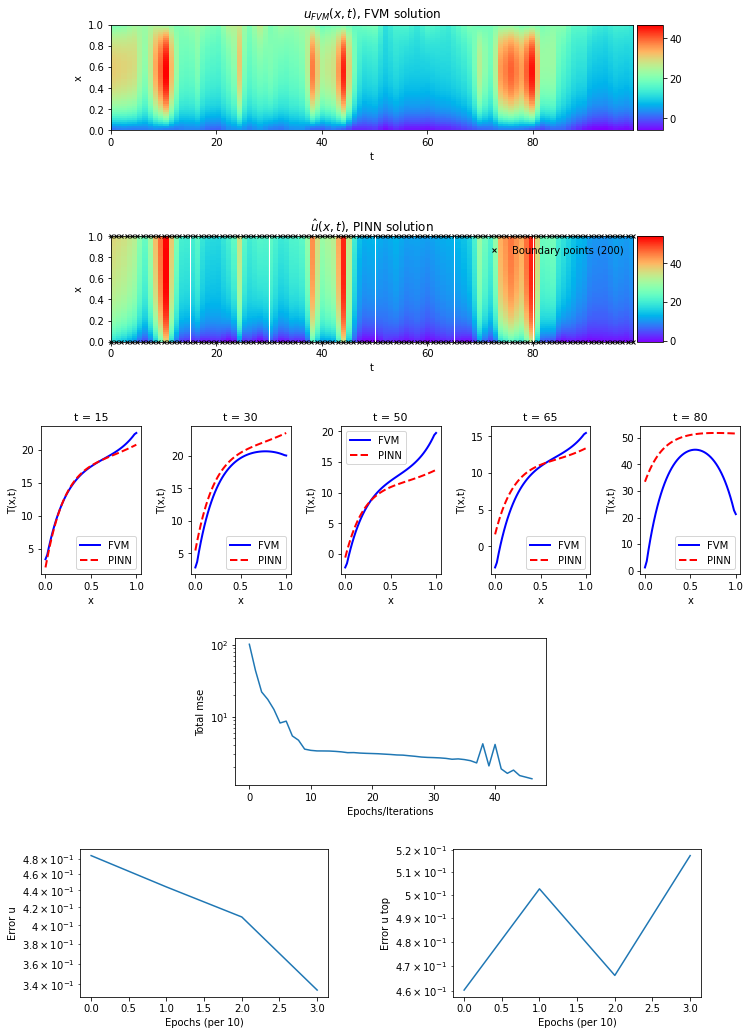

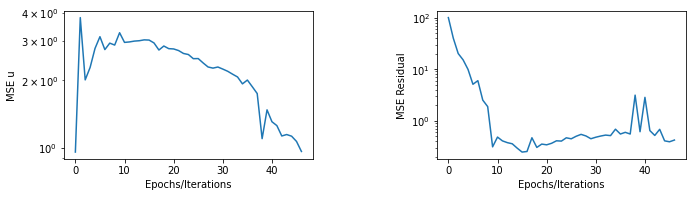

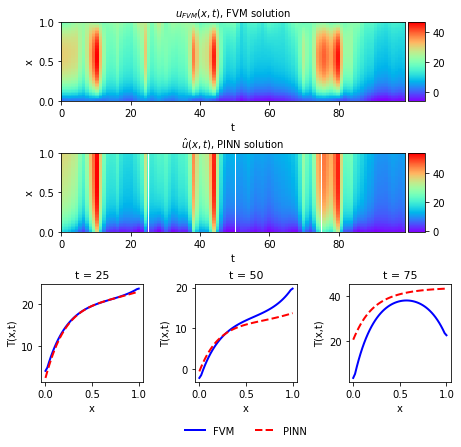


 ================= PREDICTION ================= 

L2 Prediction Error u: 2.683329e-01
L2 Error u_top: 6.269997e-01


No handles with labels found to put in legend.
No handles with labels found to put in legend.


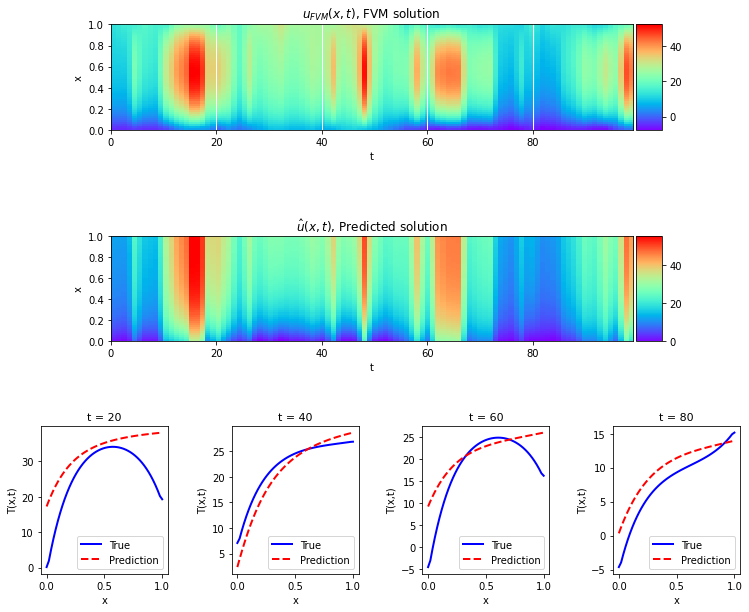


--------- RUN NUMBER: 2 --------- 

Hyperparameters:
{
  "Run Number": 1,
  "Timesteps": 100,
  "N_u": 200,
  "N_f": 10000,
  "layers": [
    5,
    50,
    50,
    50,
    50,
    1
  ],
  "activation": "tanh",
  "initializer": "glorot_normal",
  "log_frequency": 10,
  "tf_epochs": 0,
  "tf_lr": 0.005,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "use_SA": false,
  "tf_lr_coll": 0.005,
  "tf_lr_b": 0.005,
  "initialization_b": 1,
  "initialization_coll": 1,
  "use_scipy": true,
  "maxiter_scipy": 40,
  "maxfun_scipy": 100000,
  "maxcor_scipy": 50,
  "maxls_scipy": 50,
  "ftol_scipy": 2.220446049250313e-16,
  "weight_u": 1,
  "weight_f": 1,
  "GPU": "No"
}
TensorFlow version: 2.8.0
Eager execution: True
GPU-accerelated: False

Training started
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 5)                 0         
                                  

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


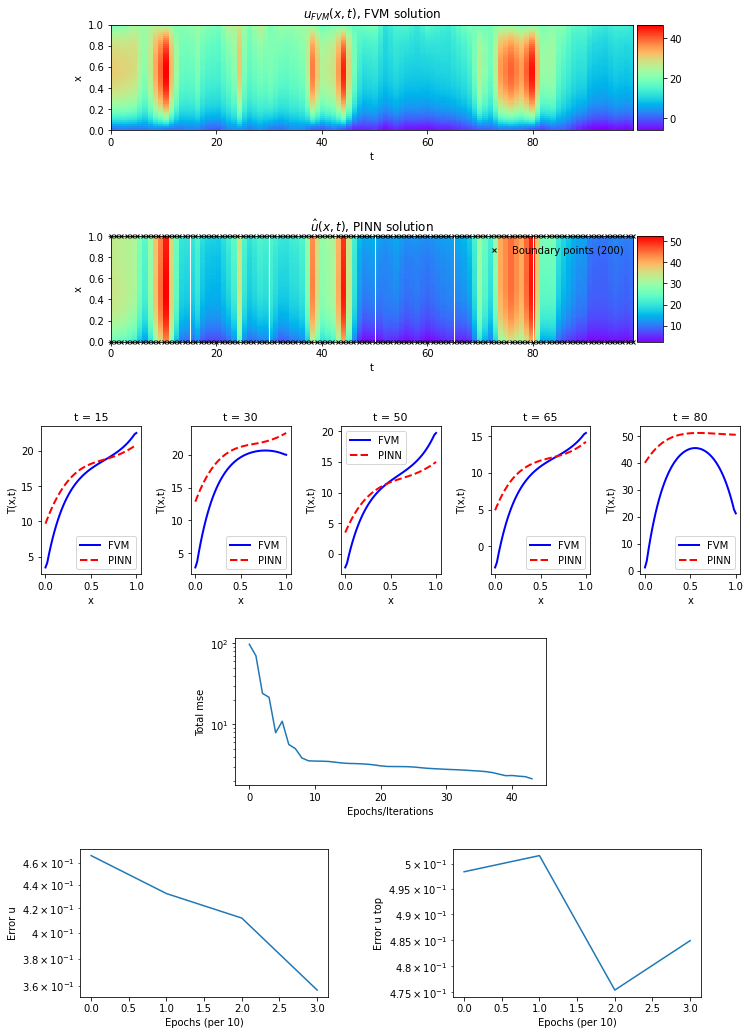

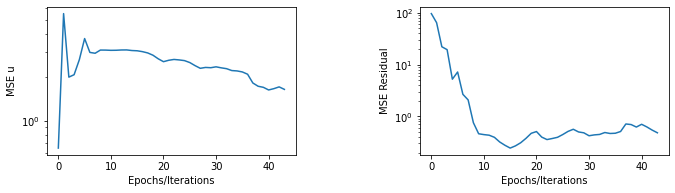

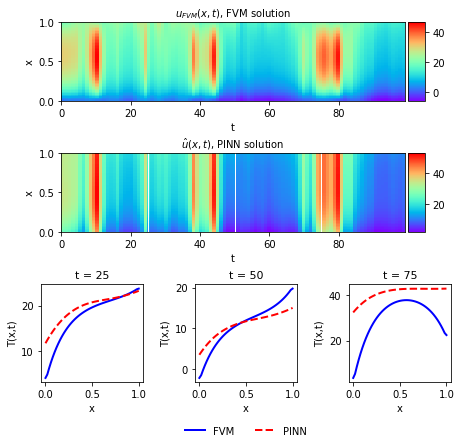


 ================= PREDICTION ================= 

L2 Prediction Error u: 3.949247e-01
L2 Error u_top: 6.684634e-01


No handles with labels found to put in legend.
No handles with labels found to put in legend.


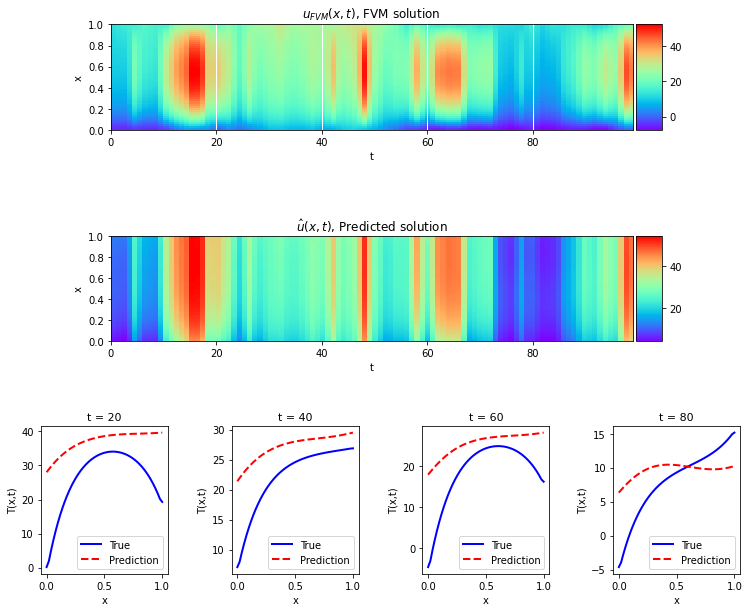


 Number of runs: 2


In [1]:
# PINN model with ambient temperature, top-oil temperature and load factor as additional inputs

# Code sources:
# https://github.com/maziarraissi/PINNs
# https://github.com/pierremtb/PINNs-TF2.0
# https://github.com/levimcclenny/SA-PINNs

# Imports
import sys
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy import optimize
from sklearn.metrics import mean_squared_error
import xlsxwriter

# Imports from python scripts
from prepare_data import prepare_data
from numerical_solution import numerical_solution
from plot_function import plot_function
from plot_small import plot_small
from Logger import Logger
from plot_function_2 import plot_function_2
from pred_data_prep import pred_data_prep
from plot_collocation import plot_collocation
from simulate_data import simulate_data

# Set random seed
#np.random.seed(1234)
#tf.random.set_seed(1234)

# PATH TO SAVE RESULTS TO
save_path = "Results/"
# LOAD WEIGHTS
path_to_weights = "" 
# SAVE WEIGHTS
weights_file = "PINN3_model"

# PINN
class PINN():
    def __init__(self, hp, logger, X_u, u, X_f, lb, ub, PK, Tamb, Ttop, P0, k, h, rho, c, u_mean, u_std, PK_f, Tamb_f, Ttop_f, pretrained_weights = None):

        self.dtype = "float64"
        self.hp = hp
        self.use_scipy = hp["use_scipy"]
        
        # Initialize Adam Optimizer
        self.tf_epochs = hp["tf_epochs"]
        self.tf_optimizer = tf.keras.optimizers.Adam(learning_rate = hp["tf_lr"], beta_1=hp["tf_b1"], epsilon=hp["tf_eps"])

        # Adam Optimizer for local weights. From: https://github.com/levimcclenny/SA-PINNs
        self.use_SA = hp["use_SA"]
        self.tf_optimizer_coll = tf.keras.optimizers.Adam(learning_rate = hp["tf_lr_coll"], beta_1=hp["tf_b1"])
        self.tf_optimizer_u = tf.keras.optimizers.Adam(learning_rate = hp["tf_lr_b"], beta_1=hp["tf_b1"])
        
        # Neural Network using Keras
        # --------------------
        layers = hp["layers"]
        tf.keras.backend.set_floatx(self.dtype)
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
        self.model.add(tf.keras.layers.Lambda(lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
        for width in layers[1:-1]:
            if hp["activation"] == "tanh":
                self.model.add(tf.keras.layers.Dense(width, activation=tf.nn.tanh, kernel_initializer=hp["initializer"]))
        self.model.add(tf.keras.layers.Dense(layers[-1], activation=None, kernel_initializer=hp["initializer"]))
        # --------------------
        
        # Load weights
        if pretrained_weights is not None:
            self.model.load_weights(pretrained_weights)

        # Storing sizes of weights & biases
        self.sizes_w = []
        self.sizes_b = []
        for i, width in enumerate(layers):
            if i != 1:
                self.sizes_w.append(int(width * layers[1]))
                self.sizes_b.append(int(width if i != 0 else layers[1]))
        
        # Logger
        self.logger = logger
        
        # Collocation and Boundary Points
        self.X_u = self.tensor(X_u)
        self.x_u = self.tensor(X_u[:,0:1])
        self.t_u = self.tensor(X_u[:,1:2])
        self.x_f = self.tensor(X_f[:, 0:1])
        self.t_f = self.tensor(X_f[:, 1:2])
        
        self.lb = lb
        self.ub = ub
        
        # Parameters
        self.u = u
        self.PK = PK
        self.Tamb = Tamb
        self.Ttop = Ttop
        self.layers = layers
        self.P0 = P0
        self.k = k
        self.h = h
        self.rho = rho
        self.c = c
        
        # Epoch counter
        self.epoch = 0
        
        # Normalizing constants
        self.u_mean = u_mean
        self.u_std = u_std

        # Paramameters for collocation points
        self.PK_f = PK_f
        self.Tamb_f = Tamb_f 
        self.Ttop_f = Ttop_f
        
    # NN
    def net_u_pk_tamb(self, X_u):
        u_pk_tamb = self.model(np.hstack((X_u, self.PK, self.Tamb, self.Ttop)))
        u = u_pk_tamb[:,0:1]
        return u

    # Residual
    def net_f(self):
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.x_f)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(self.x_f)
                tape2.watch(self.t_f)
                X_f = tf.concat([self.x_f, self.t_f], axis=1)
                
                # Prediction
                u = self.model(tf.concat([X_f, self.PK_f, self.Tamb_f, self.Ttop_f], axis = 1))
                
                # Denormalize prediction
                u = tf.multiply(u, self.u_std)
                u = tf.add(u, self.u_mean)
                
            u_x = tape2.gradient(u, self.x_f)
            u_t = tape2.gradient(u, self.t_f)
            
        u_xx = tape.gradient(u_x, self.x_f) 
        del tape
        
        f = (u_t -  self.k*u_xx/(self.rho*self.c) - (self.P0 + self.PK_f - self.h*(u - self.Tamb_f))/(self.rho*self.c))
        
        return f
    
    # Loss
    def loss(self, u_PK_Tamb, u_PK_Tamb_pred, col_weights, u_weights):
        
        u_pred = self.net_u_pk_tamb(self.X_u)
        f_pred = self.net_f()
        mse_u = tf.reduce_mean(tf.square(u_pred - self.u)) 
        mse_f = tf.reduce_mean(tf.square(f_pred)) 
        #if self.use_SA:
        #    mse_u = tf.reduce_mean(tf.square(tf.multiply(u_weights, u_pred - self.u))) 
        #    mse_f = tf.reduce_mean(tf.square(tf.multiply(col_weights,f_pred)))
            
        mse_u = tf.multiply(mse_u, hp["weight_u"])
        mse_f = tf.multiply(mse_f, hp["weight_f"])

        self.logger.append_losses(mse_u.numpy(), mse_f.numpy())
        self.epoch += 1
        if self.epoch % hp["log_frequency"] == 0:
            self.logger.log_train_progress(self.epoch)
            tf.print(f"mse_u {mse_u.numpy()}   mse_f {mse_f.numpy()}")
            tf.print(f"Total mse: {mse_u + mse_f}" )
            print('----------------')
            
        return mse_u + mse_f
    
    # Predict
    def predict(self, X_star, PK, Tamb, Ttop):
        pred = self.model(np.hstack((X_star, PK, Tamb, Ttop)))
        u_pred = pred[:, 0:1]

        # Denormalize prediction
        u_pred = u_pred*self.u_std + self.u_mean
        return u_pred.numpy()

    # Training
    def fit(self, col_weights, u_weights):
        self.logger.log_train_start(self)

        # Creating the tensors
        X_u = self.tensor(self.X_u)
        u = self.u
        
        # Optimizing
        # Adam
        self.tf_optimization(X_u, u, col_weights, u_weights)
        # L-BFGS-B
        if self.use_scipy:
            self.solve_with_ScipyOptimizer(X_u, u, col_weights, u_weights)
        
        # Logger 
        self.logger.log_train_end(self.epoch)
    
    # ADAM Optimization
    def tf_optimization(self, X_u, u, col_weights, u_weights):
        self.logger.log_train_opt("Adam")
        for epoch in range(self.tf_epochs):
            #if self.use_SA:
            #    loss_value, grads, grads_col, grads_u = self.grad(X_u, u, col_weights, u_weights)
            #    self.tf_optimizer.apply_gradients(zip(grads, self.wrap_training_variables()))
            #    self.tf_optimizer_coll.apply_gradients(zip([-grads_col], [col_weights]))
            #    self.tf_optimizer_u.apply_gradients(zip([-grads_u], [u_weights]))
            #else:
            loss_value, grads = self.grad(X_u, u, col_weights, u_weights)
            self.tf_optimizer.apply_gradients(zip(grads, self.wrap_training_variables()))
    
    def grad(self, X, u, col_weights, u_weights):
        with tf.GradientTape(persistent=True) as tape:
            loss_value = self.loss(u, self.model(np.hstack((X, self.PK, self.Tamb, self.Ttop))), col_weights, u_weights)
        grads = tape.gradient(loss_value, self.wrap_training_variables())
        #if self.use_SA:
        #    grads_col = tape.gradient(loss_value, col_weights)
        #    grads_u = tape.gradient(loss_value, u_weights)
        #    return loss_value, grads, grads_col, grads_u
        return loss_value, grads
        
    # LBFGS-B using Scipy Optimization (not available in TF + not GPU supported)
    def solve_with_ScipyOptimizer(self, X_u, u, col_weights, u_weights):
        self.logger.log_train_opt("LBFGS-B with scipy")
        loss_and_flat_grad = self.get_loss_and_flat_grad(X_u, u, col_weights, u_weights)
        return scipy.optimize.minimize(loss_and_flat_grad, x0=self.get_weights(),
                                       jac=True,
                                       method='L-BFGS-B', options = {'maxiter': hp["maxiter_scipy"], 
                                                                     'maxfun': hp["maxfun_scipy"],
                                                                     'maxcor': hp["maxcor_scipy"] ,
                                                                     'maxls': hp["maxls_scipy"],
                                                                     'ftol' : hp["ftol_scipy"],
                                                                     'iprint': 0})
    
    # Helpers for optimization:
    def wrap_training_variables(self):
        var = self.model.trainable_variables
        return var

    # L-BFGS weight getting and setting. From: https://github.com/pierremtb/PINNs-TF2.0
    def get_weights(self, convert_to_tensor=True):
        w = []
        for layer in self.model.layers[1:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)
        if convert_to_tensor:
            w = self.tensor(w)
        return w
    
    def set_weights(self, w):
        for i, layer in enumerate(self.model.layers[1:]):
            start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
            end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(self.sizes_w[i] / self.sizes_b[i])
            weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
            biases = w[end_weights:end_weights + self.sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)

    def get_loss_and_flat_grad(self, X, u, col_weights, u_weights):
        def loss_and_flat_grad(w):
            with tf.GradientTape() as tape2:
                self.set_weights(w)
                loss_value = self.loss(u, self.model(np.hstack((X, self.PK, self.Tamb, self.Ttop))), col_weights, u_weights)
            grad = tape2.gradient(loss_value, self.wrap_training_variables())
            grad_flat = []
            for g in grad:
                grad_flat.append(tf.reshape(g, [-1]))
            grad_flat = tf.concat(grad_flat, 0)
            return loss_value.numpy(), grad_flat.numpy() 
        return loss_and_flat_grad

    # General helpers:
    def summary(self):
        return self.model.summary()
    def tensor(self, X):
        return tf.convert_to_tensor(X, dtype=self.dtype)

def hyperparameter_loop(run_no, T_solution, N_u, N_f, layers, act_fcn, mse_wt, steps_t): 

    hp["N_u"] = N_u
    hp["N_f"] = N_f
    hp["layers"] = layers
    hp["activation"] = act_fcn
    hp["weight_u"] = mse_wt[0]
    hp["weight_f"] = mse_wt[1]

    T_tog = T_solution[0:steps_t, :]

    # Prepare data
    X_f_train, X_u_train, u_train, PK_train, Tamb_train, Ttop_train, lb, ub, X_star, u_star, PK_star, Tamb_star, Ttop_star, PK_tog, Tamb_tog, X, T, x, t, PK_f, Tamb_f, Ttop_f = prepare_data(data_df, T_tog, N_u, N_f)

    # Normalize data and get normalization constants
    u_train_norm = (u_train - np.mean(u_train)) / np.std(u_train)
    u_mean = np.mean(u_train)
    u_std = np.std(u_train)

    # Create logger
    logger = Logger(hp)

    # Variables
    P0 = 15
    k = 0.05
    h = 1
    rho = 0.9
    c = 2 

    # Initialize the model 
    ub = np.append(ub, [max(PK_train), max(Tamb_train), max(Ttop_train)])
    lb = np.append(lb, [min(PK_train), min(Tamb_train), min(Ttop_train)])
    pinn = PINN(hp, logger, X_u_train, u_train_norm, X_f_train, lb, ub, PK_train, Tamb_train, Ttop_train, P0, k, h, rho, c, u_mean, u_std, PK_f, Tamb_f, Ttop_f)
    #pinn = PINN(hp, logger, X_u_train, u_train_norm, X_f_train, lb, ub, PK_train, Tamb_train, Ttop_train, P0, k, h, rho, c, u_mean, u_std, PK_f, Tamb_f, Ttop_f, path_to_weights))

    # Error for top-oil temperature between FVM and PINN
    index = list(range(51,52*steps_t ,52))
    u_star_ind = u_star[index]  

    # Defining the error function for the logger
    def error():
        u_pred = pinn.predict(X_star, PK_star, Tamb_star, Ttop_star)
        u_pred_ind = u_pred[index]
        error_u = np.linalg.norm(u_pred - u_star, 2) / np.linalg.norm(u_star, 2)
        error_u_top = np.linalg.norm(u_star_ind-u_pred_ind,2)/np.linalg.norm(u_star_ind,2) 
        return [error_u, error_u_top]

    logger.set_error_fn(error)

    # Initialize local weights boundary and collocation points
    col_weights = tf.Variable(np.ones((hp["N_f"], 1), 'float64'), trainable = True)
    u_weights = tf.Variable(np.ones((hp["N_u"], 1), 'float64'), trainable = True)

    # Training the PINN
    pinn.fit(col_weights, u_weights)

    epochs = pinn.epoch
    time = pinn.logger.get_elapsed()

    mse_u_final, mse_f_final, mse_final = pinn.logger.get_final_losses_lists_2()
    mse_u, mse_f, mse, error_u_list, error_u_top_list = pinn.logger.get_losses_lists_2()

    # PREDICTIONS AND ERRORS
    u_pred = pinn.predict(X_star, PK_star, Tamb_star, Ttop_star)

    # Error between FVM results and predictions by PINN
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)   
    print('Error u, L2: %e' % (error_u))
    error_u_RMSE = mean_squared_error(u_star, u_pred, squared=False)
    print('Error u, RMSE: %e' % (error_u_RMSE))                    

    # Error for top-oil temperature between FVM and PINN
    index = list(range(51,52*steps_t,52))
    u_star_ind = u_star[index]
    u_pred_ind = u_pred[index]
    error_u_top = np.linalg.norm(u_star_ind-u_pred_ind,2)/np.linalg.norm(u_star_ind,2)   
    print('Error u_top: %e' % (error_u_top))

    # Collect Other errors FVM and PINN
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    Error_u = np.abs(T_tog - U_pred)

    # Plotting
    filename = "plot_" + str(run_no)
    filepath = save_path + filename
    time_list = [15, 30 ,50, 65, 80]
    plot_function(filepath, x, t, T_tog, U_pred, X_u_train, u_train, mse, error_u_list, error_u_top_list, mse_u, mse_f, time_list, hp["log_frequency"])
    plot_small(filepath, x, t, T_tog, U_pred, [25, 50, 75])
    plt.show()

    # Collocation point weights
    #plt.scatter(X_f_train[:, 1], X_f_train[:, 0], c = col_weights.numpy(), s = col_weights.numpy()/10)
    #plt.show()

    # Save weights of PINN
    pinn.model.save_weights(save_path + weights_file + '_' + str(run_no) + '.h5')

    # Prediction
    print('\n ================= PREDICTION ================= \n')

    N_pred = 100
    T_tog_preds = T_solution[steps_t:steps_t + N_pred, :]

    X_star_preds, PK_star_preds, Tamb_star_preds, Ttop_star_preds, X_preds, T_preds, u_star_preds = pred_data_prep(data_df, T_tog_preds, steps_t)
    u_pred_preds = pinn.predict(X_star_preds, PK_star_preds, Tamb_star_preds, Ttop_star_preds)

    # Error between FVM results and predictions by PINN
    error_u_pred = np.linalg.norm(u_star_preds-u_pred_preds,2)/np.linalg.norm(u_star_preds,2)
    print('L2 Prediction Error u: %e' % (error_u_pred))

    # Error for top-oil temperature between FVM and PINN
    index = list(range(51,5200,52))
    u_star_ind = u_star_preds[index]
    u_pred_ind = u_pred_preds[index]
    pred_error_u_top = np.linalg.norm(u_star_ind-u_pred_ind,2)/np.linalg.norm(u_star_ind,2)   
    print('L2 Error u_top: %e' % (pred_error_u_top))

    # Collect Other errors FVM and PINN
    U_pred_preds = griddata(X_star_preds, u_pred_preds.flatten(), (X_preds, T_preds), method='cubic')
    Error_u = np.abs(T_tog_preds - U_pred_preds)

    # Plot solution compared to FVM for predicted part
    filename = "pred_plot_" + str(run_no)
    filepath = save_path + filename
    plot_function_2(filepath, T_tog_preds, U_pred_preds, [20, 40, 60, 80])

    return [error_u, error_u_RMSE, error_u_top, epochs, time, mse_final, mse_u_final, mse_f_final, error_u_pred, pred_error_u_top]

# Load Data - time series Ta, To & K
data_df = simulate_data()

# Numerical Solution
T_solution = numerical_solution(data_df.iloc[0:500, :], 50, c=2)

# Hyperparameters 
hp = {}

# For storing run number later
hp["Run Number"] = 0

# Timesteps to include
hp["Timesteps"] = 100

# Collocation points on the boundaries
hp["N_u"] = 200
# Collocation points on the domain
hp["N_f"] = 10000
# Layers
hp["layers"] = [5, 50, 50, 50, 50, 1]
# Activation Function
hp["activation"] = "tanh"
# Initialization
hp["initializer"] = "glorot_normal"

# How often to Display Epochs
hp["log_frequency"] = 10 

# Adam optimizer
hp["tf_epochs"] = 0
hp["tf_lr"] = 0.005
hp["tf_b1"] = 0.99
hp["tf_eps"] = 1e-1
# Learning rate boundary and collocation weights
hp["use_SA"] = False
hp["tf_lr_coll"] = 5e-3
hp["tf_lr_b"] = 5e-3
hp["initialization_b"] = 1
hp["initialization_coll"] = 1

# LBGFS-B optimizer
hp["use_scipy"] = True
hp["maxiter_scipy"] = 2000 
hp["maxfun_scipy"] = 100000
hp["maxcor_scipy"] = 50
hp["maxls_scipy"] = 50
hp["ftol_scipy"] = 1.0 * np.finfo(float).eps

# Weight MSE terms
hp["weight_u"] = 1
hp["weight_f"] = 1

# Hyperparameter combinations to run
N_u = [200]
N_f = [10000]
layers = [[5, 50, 50, 50, 50, 1]]
plot_bool = True
activ_fcns = ["tanh"]
weights_mse = [[1, 1]]
timesteps = [100]

# Start loop
run_number = 1
d_hp = {}
d_res = {}
random_seeds = 5

for ii in range(len(N_u)):
    for jj in range(len(N_f)):
        for kk in range(len(layers)):
            for ll in range(len(activ_fcns)):
                for mm in range(len(weights_mse)):
                    for nn in range(len(timesteps)):
                        for oo in range(random_seeds):

                            print("\n--------- RUN NUMBER: "+ str(run_number) + " --------- \n")

                            results = hyperparameter_loop(run_number, T_solution, N_u[ii], N_f[jj], layers[kk], activ_fcns[ll], weights_mse[mm], timesteps[nn])

                            hp["Run Number"] = run_number
                            d_hp["dataframe_hp_"+str(run_number)] = pd.DataFrame()
                            if tf.test.is_gpu_available():
                                hp["GPU"] = "Yes"
                            else:
                                hp["GPU"] = "No"
                            d_hp["dataframe_hp_"+str(run_number)] = d_hp["dataframe_hp_"+str(run_number)].append(hp, ignore_index=True)

                            results_dict = {
                              "Run Number": run_number,
                              "error_u": results[0],
                              "error_u_RMSE": results[1],
                              "error_u_top": results[2],
                              "epochs": results[3],
                              "total time": results[4],
                              "Final mse" : results[5],
                              "mse_u" : results[6],
                              "mse_pk" : results[7],
                              "error_u_pred": results[8],
                              "error_u_top_pred": results[9]
                            }

                            d_res["dataframe_results_"+str(run_number)] = pd.DataFrame()
                            d_res["dataframe_results_"+str(run_number)] = d_res["dataframe_results_"+str(run_number)].append(results_dict, ignore_index=True)

                            run_number += 1

print("\n =========================== \n Number of runs: " + str(run_number - 1))

# Save results and hyperparameters to Excel
writer = pd.ExcelWriter(save_path + 'Results.xlsx', engine='xlsxwriter')   
workbook=writer.book
worksheet=workbook.add_worksheet('Res_hps')
writer.sheets['Res_hps'] = worksheet

for i, df_name in enumerate(d_res): 
    d_res[df_name].to_excel(writer, sheet_name='Res_hps', startrow=5*i, startcol=0)   
for x, df_name in enumerate(d_hp): 
    d_hp[df_name].to_excel(writer, sheet_name='Res_hps', startrow=5*x + 2, startcol=0)   

writer.save()